add photo here - maybe of books? or a library card? 

# A Data-driven Approach for Library Inventory
### Author: Sarah Prusaitis

## Project Overview

This project aims to enhance inventory management at the Seattle Public Library by leveraging historical checkout data of both physical and digital books. By analyzing trends and patterns in the dataset spanning 2022-2023, the project seeks to provide actionable recommendations for optimizing the library's collection. Through predictive modeling, it aims to forecast future demand for various titles, enabling the library to better allocate resources and meet the needs of its patrons efficiently.

## Business Understanding

The primary objective of this project is to assist the Seattle Public Library in optimizing its inventory management system. By analyzing historical checkout data, the project aims to address the challenge of efficiently allocating resources for physical and digital book collections. The library's stakeholders seek insights into trends and preferences among its patrons to anticipate future demand accurately. Through predictive analytics, the project will deliver actionable recommendations to XYZ ( still deciding )

## Data Understanding

The dataset provided by The Seattle Public Library comprises 5.21 million rows and 12 columns, documenting the checkout records of both physical and electronic items over the years 2022 and 2023. Each row represents the number of checkouts for a specific title in a given month of the year. With this rich dataset, the project endeavors to understand the borrowing patterns of library users and identify key factors influencing the demand for books in both formats.

In [1]:
#import needed packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# Reading in data and looking at head

df = pd.read_csv('Data/Checkouts_by_Title_2022_2023.csv', low_memory = False)
df.head()

,UsageClass,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,ISBN,Creator,Subjects,Publisher,PublicationYear
0,Physical,Horizon,BOOK,2022,9,6,Great day for up! Pictures by Quentin Blake.,"0394829131, 0394929136","Seuss, Dr.",Stories in rhyme,"Beginner Books,",[1974]
1,Digital,OverDrive,AUDIOBOOK,2022,9,1,The Scientist and the Spy: A True Story of Chi...,9780593166819,Mara Hvistendahl,"Business, Politics, True Crime, Nonfiction",Books on Tape,2020
2,Digital,OverDrive,EBOOK,2022,9,3,The Flame and the Flower,9780061743696,Kathleen E. Woodiwiss,"Fiction, Romance, Historical Fiction",HarperCollins Publishers Inc.,2006
3,Digital,OverDrive,EBOOK,2022,9,8,Fifty Words for Rain: A Novel,9781524746377,Asha Lemmie,"Fiction, Literature, Historical Fiction","Penguin Group (USA), Inc.",2020
4,Physical,Horizon,BOOK,2022,9,5,How to code a rollercoaster / by Josh Funk ; i...,"0425292037, 9780425292037","Funk, Josh","Amusement parks Juvenile fiction, Computer pro...","Viking,",[2019]


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5207534 entries, 0 to 5207533
Data columns (total 12 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   UsageClass       object
 1   CheckoutType     object
 2   MaterialType     object
 3   CheckoutYear     int64 
 4   CheckoutMonth    int64 
 5   Checkouts        object
 6   Title            object
 7   ISBN             object
 8   Creator          object
 9   Subjects         object
 10  Publisher        object
 11  PublicationYear  object
dtypes: int64(2), object(10)
memory usage: 476.8+ MB


In [4]:
df['MaterialType'].value_counts()

BOOK                                          2061373
EBOOK                                         1679018
AUDIOBOOK                                      889842
VIDEODISC                                      313940
SOUNDDISC                                      225249
REGPRINT                                        15694
MUSIC                                            7673
LARGEPRINT                                       4576
SOUNDDISC, VIDEODISC                             2024
ER, SOUNDREC                                     1443
SOUNDREC                                         1054
ER                                                933
CR                                                905
MAP                                               702
VIDEO                                             699
ATLAS                                             430
ER, SOUNDDISC                                     429
ER, VIDEODISC                                     391
VISUAL                      

Filtering data to only physical books and digital books, LARGEPRINT is books that were printed in a larger font size to accomodate people with low vision. Upon looking at REGPRINT, they are physical books.

In [5]:
df.drop(df[~df['MaterialType'].isin(['BOOK', 'EBOOK', 'LARGEPRINT', 'REGPRINT'])].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,UsageClass,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,ISBN,Creator,Subjects,Publisher,PublicationYear
0,Physical,Horizon,BOOK,2022,9,6,Great day for up! Pictures by Quentin Blake.,"0394829131, 0394929136","Seuss, Dr.",Stories in rhyme,"Beginner Books,",[1974]
1,Digital,OverDrive,EBOOK,2022,9,3,The Flame and the Flower,9780061743696,Kathleen E. Woodiwiss,"Fiction, Romance, Historical Fiction",HarperCollins Publishers Inc.,2006
2,Digital,OverDrive,EBOOK,2022,9,8,Fifty Words for Rain: A Novel,9781524746377,Asha Lemmie,"Fiction, Literature, Historical Fiction","Penguin Group (USA), Inc.",2020
3,Physical,Horizon,BOOK,2022,9,5,How to code a rollercoaster / by Josh Funk ; i...,"0425292037, 9780425292037","Funk, Josh","Amusement parks Juvenile fiction, Computer pro...","Viking,",[2019]
4,Digital,OverDrive,EBOOK,2022,9,1,How to Be Yourself: Quiet Your Inner Critic an...,9781250122230,Ellen Hendriksen,"Psychology, Self-Improvement, Nonfiction, Self...",Macmillan Publishers,2018


In [6]:
# Combine 'CheckoutYear' and 'CheckoutMonth' into a datetime column and dropping unnecessary columns 

df['CheckoutDate'] = pd.to_datetime(df['CheckoutYear'].astype(str) + '-' + 
                                    df['CheckoutMonth'].astype(str), format='%Y-%m')
df.drop(['CheckoutYear', 'CheckoutMonth', 'CheckoutType', 'MaterialType'], axis=1, inplace = True)
df.head()

,UsageClass,Checkouts,Title,ISBN,Creator,Subjects,Publisher,PublicationYear,CheckoutDate
0,Physical,6,Great day for up! Pictures by Quentin Blake.,"0394829131, 0394929136","Seuss, Dr.",Stories in rhyme,"Beginner Books,",[1974],2022-09-01
1,Digital,3,The Flame and the Flower,9780061743696,Kathleen E. Woodiwiss,"Fiction, Romance, Historical Fiction",HarperCollins Publishers Inc.,2006,2022-09-01
2,Digital,8,Fifty Words for Rain: A Novel,9781524746377,Asha Lemmie,"Fiction, Literature, Historical Fiction","Penguin Group (USA), Inc.",2020,2022-09-01
3,Physical,5,How to code a rollercoaster / by Josh Funk ; i...,"0425292037, 9780425292037","Funk, Josh","Amusement parks Juvenile fiction, Computer pro...","Viking,",[2019],2022-09-01
4,Digital,1,How to Be Yourself: Quiet Your Inner Critic an...,9781250122230,Ellen Hendriksen,"Psychology, Self-Improvement, Nonfiction, Self...",Macmillan Publishers,2018,2022-09-01


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760661 entries, 0 to 3760660
Data columns (total 9 columns):
 #   Column           Dtype         
---  ------           -----         
 0   UsageClass       object        
 1   Checkouts        object        
 2   Title            object        
 3   ISBN             object        
 4   Creator          object        
 5   Subjects         object        
 6   Publisher        object        
 7   PublicationYear  object        
 8   CheckoutDate     datetime64[ns]
dtypes: datetime64[ns](1), object(8)
memory usage: 258.2+ MB


In [8]:
df.isnull().sum()

UsageClass              0
Checkouts               0
Title                   0
ISBN               639454
Creator            101247
Subjects            27281
Publisher           12668
PublicationYear     12323
CheckoutDate            0
dtype: int64

In [9]:
# Clean and standardize PublicationYear column

df['PublicationYear'] = df['PublicationYear'].str.extract(r'(\d{4})')

In [10]:
# Replace any missing publication years with 0000 

df['PublicationYear'].fillna("0000", inplace=True)

In [11]:
df['PublicationYear'].value_counts().head(50)

2021    401339
2022    365971
2020    330998
2019    286203
2018    262590
2017    248734
2013    229623
2016    202126
2015    200544
2014    189596
2011    168017
2012    149335
2023    142235
2010    119878
2009     87316
2008     61875
2007     35521
2006     30259
2005     30098
2004     18153
2003     17402
2002     15258
2001     13878
2000     12761
0000     12469
1999     11093
1998      9780
1997      8489
1996      7740
1995      7685
1994      6763
1993      5668
1992      5417
1990      4477
1991      4413
1989      3927
1988      3459
1987      3180
1986      3125
1985      2512
1984      2035
1983      1980
1982      1746
1981      1622
1977      1567
1980      1534
1978      1531
1972      1461
1973      1405
1979      1390
Name: PublicationYear, dtype: int64

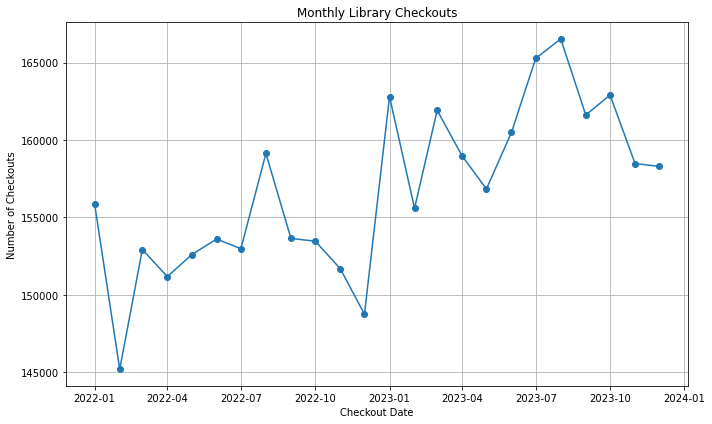

In [12]:
# Grouping by month and looking at the number of checkouts per month

monthly_checkouts = df.groupby(df['CheckoutDate'].dt.to_period('M')).size()

plt.figure(figsize=(10, 6))
plt.plot(monthly_checkouts.index.to_timestamp(), monthly_checkouts.values, marker='o', linestyle='-')
plt.title('Monthly Library Checkouts')
plt.xlabel('Checkout Date')
plt.ylabel('Number of Checkouts')
plt.grid(True)
plt.xticks()
plt.tight_layout()
plt.show()

In [13]:
df['Creator'].value_counts().head(25)

James Patterson                         5573
Patterson, James, 1947-                 4197
Nora Roberts                            3706
Geronimo Stilton                        3479
DK                                      3263
Stan Berenstain                         2715
Hunter, Erin                            2626
Erin Hunter                             2553
Agatha Christie                         2535
Osborne, Mary Pope                      2485
Stilton, Geronimo                       2424
Warner, Gertrude Chandler, 1890-1979    2403
Mary Pope Osborne                       2316
Rylant, Cynthia                         2261
Willems, Mo                             2187
Stephen King                            2166
Christie, Agatha, 1890-1976             2095
America's Test Kitchen                  2093
Pilkey, Dav, 1966-                      2067
Daisy Meadows                           2022
Seuss, Dr.                              1970
Debbie Macomber                         1937
Dan Gutman

In [14]:
# Standardizing the 'Creator' column so all authors names are in the same format

def standardize_creator(name):
    if isinstance(name, str):  # Check if the value is a string
        # Remove any additional information in parentheses
        if '(' in name and ')' in name:
            name = name.split(' (')[0]  # Extract primary name
        # Remove numbers
        name = re.sub(r'\d+', '', name)
        # Remove dashes if not part of a hyphenated name
        name = re.sub(r'(?<![a-zA-Z0-9])-|-(?![a-zA-Z0-9])', '', name)
        # If the name is in the format "Last, First"
        if ',' in name:
            parts = name.split(',')
            # If there is a comma after the first name
            if len(parts) > 2:
                name = parts[0] + ',' + ''.join(parts[1:])
            return name.strip()
        # If the name is in the format "First Last"
        elif ' ' in name:
            parts = name.split(' ')
            last = parts[-1]  # Last word is considered as the last name
            first = ' '.join(parts[:-1])  # Join the remaining as first name
            return f"{last}, {first}"
        else:
            return name.strip()
    else:
        return name

# Applying the function to standardize the 'Creator' column

df['Creator'] = df['Creator'].apply(standardize_creator)
df['Creator'].fillna('Unknown', inplace = True)

In [16]:
# Sanity check to make sure function ran correctly 

df['Creator'].value_counts().head(25)

Unknown                      101304
Patterson, James               9770
Stilton, Geronimo              5903
Hunter, Erin                   5179
Christie, Agatha               4959
Osborne, Mary Pope             4801
Warner, Gertrude Chandler      4572
Roberts, Nora                  4433
Meadows, Daisy                 3777
Pilkey, Dav                    3680
Berenstain, Stan               3663
Gutman, Dan                    3557
King, Stephen                  3489
DK                             3263
Holub, Joan                    3124
Seuss, Dr.                     3034
Keene, Carolyn                 2931
Steel, Danielle                2835
Macomber, Debbie               2718
Rylant, Cynthia                2648
Perry, Anne                    2639
Woods, Stuart                  2616
Peirce, Lincoln                2590
Riordan, Rick                  2404
Dean, James                    2388
Name: Creator, dtype: int64

In [18]:
# Clean 'Title' column
df['Title'] = df['Title'].apply(lambda x: x.title())

In [ ]:
df.head(50)

In [1]:
# Function to remove creator names from titles
#def remove_creator_from_title(title, creator):
    # If the creator's name is found in the title, remove it
 #   title = re.sub(re.escape(creator), '', title, flags=re.IGNORECASE)
  #  return title.strip()

# Iterate over each row and remove creator names from titles
#for index, row in df.iterrows():
#    df.at[index, 'Title'] = remove_creator_from_title(row['Title'], row['Creator'])


In [ ]:
# Grouping by title and counting checkouts
checkout_counts_per_title = df.groupby('Title').size().sort_values(ascending=False)

In [ ]:
checkout_counts_per_title.head(50)

In [ ]:
# Select top N titles
top_n = 10  # Change this number to get more or fewer top titles
top_titles = checkout_counts_per_title.head(top_n)

plt.figure(figsize=(12, 6))
top_titles.plot(kind='bar', color='skyblue')
plt.title('Top {} Titles by Checkouts'.format(top_n))
plt.xlabel('Title')
plt.ylabel('Number of Checkouts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df['ISBN'].value_counts().head(20)